In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import jax
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import System_ModelKnown

from plot import plot

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, -1], dtype=float)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0

In [ ]:
def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    m, b = gs

    x, y = true

    return jnp.array([y, m * (1 - x**b) * y - x])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    m, b = cs

    x, y = nudged

    return jnp.array([y, m * (1 - x**b) * y - x])


# System evolution parameters
gs = m, b = 0.01, 2.15
gs = jnp.array(gs, dtype=complex)
c1, c2 = gs
c1 *= 1.2
c2 *= 1.2
cs = jnp.array([c1, c2], dtype=complex)

mu = 1
observed_slice = jnp.s_[:]
system = System_ModelKnown(
    mu,
    gs,
    cs,
    observed_slice,
    assimilated_ode,
    true_ode,
    complex_differentiation=True,
)

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)
optimizer = optax.adam(3e-3)
optimizer = optim.OptaxWrapper(system, optimizer)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 4000
t_relax = 5

true0, assimilated0 = get_initial_values()

true_solver = solver
trues, tls_ = true_solver.solve_true(true0, T0, Tf, dt)

true_observed = trues[(slice(None),) + system.observed_slice]

cs, u_errors, tls, assimilateds = utils.run_update(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    t_relax,
    assimilated0,
    optimizer=optimizer,
    return_all=True,
    parameter_update_option=utils.ParameterUpdateOption.mean_gradient,
)
tls_all = np.arange(len(trues)) * dt

/home/schilln/documents/otf/.venv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=float64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/home/schilln/documents/otf/.venv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:152: ComplexWarning: Casting complex values to real discards the imaginary part
  return lax_internal._convert_element_type(out, dtype, weak_type)


/home/schilln/documents/otf/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/schilln/documents/otf/.venv/lib/python3.10/site-packages/numpy/ma/core.py:3463: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/schilln/documents/otf/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


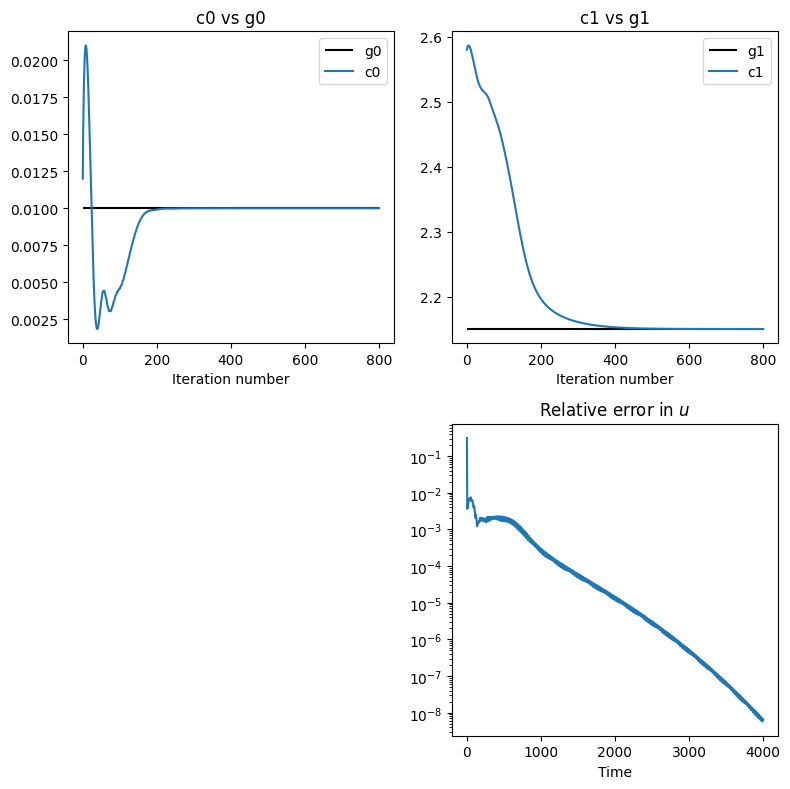

In [ ]:
fig, axs = plot(cs, u_errors, gs, tls)
fig.set_size_inches(8, 8)
fig.tight_layout()
plt.show()

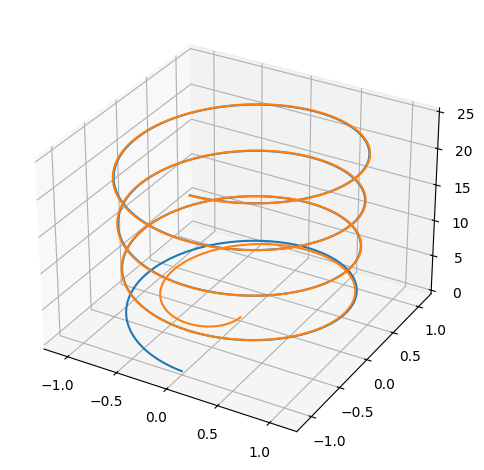

In [ ]:
fig, ax = plt.subplots(1, 1, subplot_kw={"projection": "3d"})

s_ = np.s_[:2500]
ax.plot(*trues[s_].T, tls_all[s_])
ax.plot(*assimilateds[s_].T, tls_all[s_])

fig.tight_layout()
plt.show()